## Get PDB IDs

In [1]:
deposition_group_id:str = "G-1002162".replace("-","_")
# =============================================================================

from IPython.display import HTML
from pypdb.clients.search.search_client import perform_search
from pypdb.clients.search.search_client import ReturnType
from pypdb.clients.search.operators import text_operators
from typing import List, Dict, Any

# pdbx_deposit_group.group_id
search_operator = text_operators.ExactMatchOperator(value=deposition_group_id,
                                                    attribute="pdbx_deposit_group.group_id")
pdb_ids: List[str] = perform_search(search_operator, ReturnType.ENTRY)

print(f'Found {len(pdb_ids)} entries')

Querying RCSB Search using the following parameters:
 {"query": {"type": "terminal", "service": "text", "parameters": {"attribute": "pdbx_deposit_group.group_id", "operator": "exact_match", "value": "G_1002162"}}, "request_options": {"return_all_hits": true}, "return_type": "entry"} 

Found 52 entries


## Get metatdata

Such as ligand names

In [2]:
# get the Subject of Investigation
# I honestly do not know who to fish out the "Subject of Investigation"
# the website of the PDB has it... but not the API

import pyrosetta_help as ph
import operator
import requests
import re
from typing import List

# -------------------------------------------------------------------------------------------------------

# get all the cofactor codes
ligandhunter = ph.LigandHunter.__new__(ph.LigandHunter)
cofactor_codes = ligandhunter.cofactor_codes
cofactor_codes += ['GDP', 'MES', 'ACP', 'ACT', 'DMS']

def get_novel_comp_id(pdb_id:str) -> List[str]:
    response = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/ligand_monomers/{pdb_id.lower()}')
    response.raise_for_status()
    data = response.json()[pdb_id.lower()]
    comp_id_iter = map(operator.itemgetter('chem_comp_id'), data)
    return [comp_id for comp_id in comp_id_iter if comp_id not in cofactor_codes]

def get_ligand_data(ligand_resn:str) -> Dict[str, Any]:
    response = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/compound/summary/{ligand_resn}')
    response.raise_for_status()
    return response.json()[ligand_resn.upper()][0]

def get_title(pdb_id:str) -> str:
    response = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/summary/{pdb_id.lower()}')
    response.raise_for_status()
    data = response.json()[pdb_id.lower()]
    return data[0]["title"]

# -------------------------------------------------------------------------------------------------------

metadata = [dict(pdb_id=pdb_id, type='hit') for pdb_id in pdb_ids]

# download pdbs
for data in metadata:
    data['pdb_filename']:str = ph.download_pdb(data['pdb_id'])
# get ligand
for data in metadata:
    data['ligand_resn']:str = get_novel_comp_id(data['pdb_id'])[0]


# The list of dict is not yet converted into a pandas dataframe
# as it needs splitting up, which is easier done in a for loop!

for data in metadata:

    # ## get ligand info
    response_data = get_ligand_data(data['ligand_resn'])
    data['systematic_name']: str = response_data['systematic_names'][0]['name']
    data['SMILES']:str = response_data['smiles'][0]['name']
    data['chembl_id']:str = response_data['chembl_id']
    data['formal_charge']:str = response_data['formal_charge']

    # ## get the title from the PDB
    title: str = get_title(data['pdb_id'])
    if 'in complex with ' in title:  # it;s a panDDA deposition...
        data['ligand_name'] = re.search(r'in complex with ([\w\-]+)', title).group(1)
    else:
        print('title issue for: ', data['pdb_id'], title)

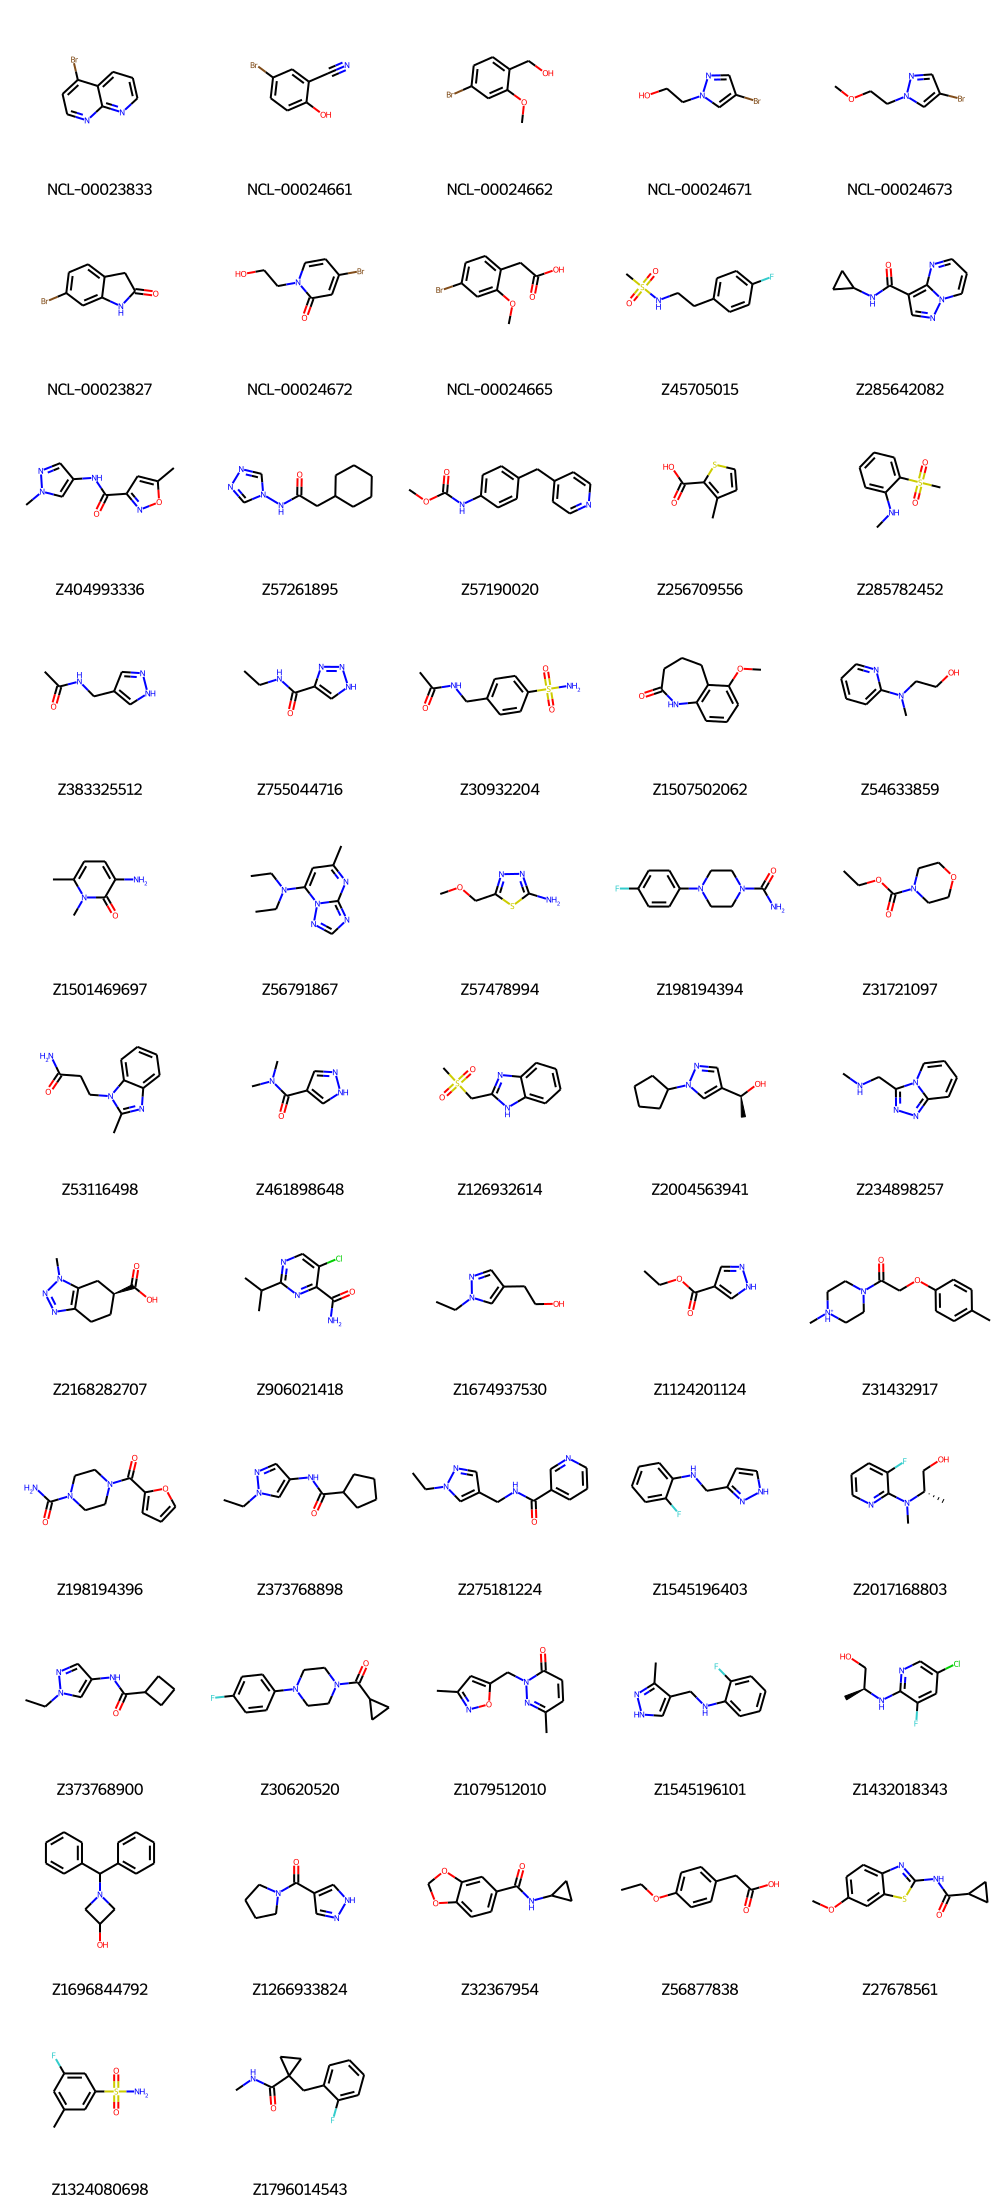

In [3]:
from rdkit import Chem

Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(d['SMILES']) for d in metadata],
                          molsPerRow=5, maxMols=100,
                         legends=[d['ligand_name'] for d in metadata])

In [ ]:
# the paper runs of different names than the IDs which seem like Zinc IDs

# https://github.com/samplchallenges/SAMPL7/tree/master/protein_ligand
# https://github.com/samplchallenges/SAMPL7/blob/master/protein_ligand/fragments_screened.csv
from github import Github
from github.ContentFile import ContentFile

repo = Github().get_user('samplchallenges').get_repo('SAMPL7')
raw:str = repo.get_contents('protein_ligand/fragments_screened.csv').decoded_content.decode('utf8')

label2smiles: Dict[str, str] = dict([line.split(',') for line in raw.strip().split('\r\n')])
label2mol: Dict[str, Chem.Mol] = {k: Chem.MolFromSmiles(v) for k, v in label2smiles.items()}

for data in metadata:
    hit:Chem.Mol = Chem.MolFromSmiles(data['SMILES'])
    for label, mol in label2mol.items():
        if not mol.HasSubstructMatch(hit):
            continue
        data['paper_name'] = label
        break
    else:
        for label, mol in label2mol.items():
        if mol.HasSubstructMatch(Chem.MolFromSmiles('CN1CCN(CC1)C(=O)COc2ccc(C)cc2')):
            print(f"{data['ligand_name']} aka {label} unmatched {data['SMILES']}")
            break

The following compound gave issues in matching:

Z31432917 aka F488 unmatched C[NH+]1CCN(CC1)C(=O)COc2ccc(C)cc2
This hit, 5RKH, is fine. The protonation was confusing RDKit.

In [ ]:
# as mentioned some entries have two hits:

import nglview as nv

nv.show_pdbid('5RJJ')

## Extraction
Of the various `pbd_filename` files, one gave trouble: `5RJJ`, F1 is present twice and is covalent in one site.
The bonding is odd as the product ought to be without the halide as it's a nucleophilic substitution.

As a result, the 5RJJ was edited manually to remove the CONECTs and the LINK entries as I am guessing a covalent was not sought.

In [ ]:
# something _was_ very off with PDB:5rjj HH8
# Bromine cannot only have one bond. The covalent compound has something else...
# dative bond?? Shmeh

import nglview as nv

view = nv.show_pdbid('5RJJ')
view._js(f"""const comp = this.stage.compList[0]
                                 const target_sele = new NGL.Selection('[HH8]');
                                 const radius = 5;
                                 const neigh_atoms = comp.structure.getAtomSetWithinSelection( target_sele, radius );
                                 const resi_atoms = comp.structure.getAtomSetWithinGroup( neigh_atoms );
                                 comp.addRepresentation( "line", {{sele: resi_atoms.toSeleString(),
                                                                   colorValue: "gainsboro",
                                                                   multipleBond: true}} );
                                 comp.addRepresentation( "contact", {{sele: resi_atoms.toSeleString()}});
                            """)
view

In [ ]:
# extract mols
from rdkit import Chem, IPythonConsole
from fragmenstein import Victor

for data in metadata:
    data['mol']: Chem.Mol = Victor.extract_mol(name=data['paper_name'],
                                     ligand_resn=data['ligand_resn'],
                                     filepath=data['pdb_filename'],
                                     smiles=data['SMILES'],
                                     throw_on_error=True
                                    )

In [ ]:
# split the data up

import pandas as pd

newmd = []
for data in metadata:
    frags = Chem.GetMolFrags(data['mol'], asMols=True)
    if len(frags) == 1:
        newmd.append(data)
        continue
    for i, mol in enumerate(frags):
        moddata = data.copy()
        moddata['mol'] = mol
        moddata['paper_name'] +=  chr(0x41+i)  # 0x41 is A
        newmd.append(moddata)

md = pd.DataFrame(newmd)
md.to_pickle('metadata_table.p')
md